## Preprocessingte Standartlaştırma ve ML İşlemi
Öncelikle temizlenmiş verisetini dahil etmek için gerekli ortamalrı kuralım.

In [1]:
import pandas as pd

In [2]:
dataCleaned = pd.read_csv('dataPreprocessed.csv')
df = dataCleaned.copy()

Bağımlı (y) ve bağımsız değişkenleri (X) tanımlayalım.

In [4]:
X = df.drop(columns = 'price')
y = df.price

Verileri train teste ayıralım.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Veriyi standartize ettikten sonra eğitim için hazırlayalım. Normalde eskiden bunları tek tek yapardım ama artık Pipeline ile hem Standard Scale ediyoruz hem de eiğitiyoruz ve bizi kod karmaşasından kurtarıyor.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [13]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X.select_dtypes('int').columns)],
    remainder = 'passthrough'
)

pipeLinearRegModel = Pipeline([
    ('preprocessor', preprocessor), #scale edecek sadece sayısal değerleri
    ('linearModel', LinearRegression()) #ölçeklendirecek
])

pipeLinearRegModel.fit(X_train, y_train)
y_pred = pipeLinearRegModel.predict(X_test)

Şimdi projede linear regression kullanıldığıdaki başarı oranına ve metrik değerlerine bakalım.

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [21]:
mse = mean_squared_error(y_test, y_pred) #tahmin edilen değerle gerçek değerlerin kare farkı
np.sqrt(mse) #o yüzden bir de kökünü olarak ortalama hata payını buluyoruz.

12495.563641831064

Bu da demek oluyor ki bir evi ortalama olarak 12500 lira farkla kaçırıyor.

In [24]:
pipeLinearRegModel.score(X_test, y_test)

-1.8213259959494108

Burada da model göründüğü gibi çok başarısız oldu. Anlaşılan o ki bu model linear regression için pek uygun değil. Başka modeller deneyelim. Mesela GradientBoostingRegressor

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
pipeGBM = Pipeline([
    ('preprocessor', preprocessor), #scale edecek sadece sayısal değerleri
    ('GBM', GradientBoostingRegressor()) #ölçeklendirecek
])

pipeGBM.fit(X_train, y_train)

/Users/yitik/anaconda3/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['room', 'living_room', 'area', 'age', 'floor'], dtype='object'))])),
                ('GBM', GradientBoostingRegressor())])

In [30]:
mse = mean_squared_error(y_test, pipeGBM.predict(X_test))
np.sqrt(mse)

3215.9065037131436

In [31]:
pipeGBM.score(X_test, y_test)

0.8131262085888894

Gördüğünüz gibi modelin 3215 lira gibi bir yanılma payı oluyor. Ve model %81 başarılı görünüyor. Bunun için de ekstra bir ortalama başarı değerine bakıp model için optimum değerleri belirlemeye odaklanakım.

In [32]:
from sklearn.model_selection import cross_val_score as cv_score, GridSearchCV

In [33]:
np.mean(cv_score(pipeGBM, X_test, y_test, cv = 10))

0.7938130508538113

Farklı train test verilerinin ortlamasına baktığında şuanki model %80 civarı bir başarı oranına sahip görünüyor bu da aslında veriyi oldukça tutarlı bir şekilde temizzlemişiz demek. Overfitting gibi bir olayla karşılaşmadık.

Şimdi modeli optimize edelim.

In [38]:
param_grid = {
    'GBM__n_estimators': [100, 200, 300],
    'GBM__learning_rate': [0.01, 0.05, 0.1],
    'GBM__max_depth': [3, 5, 7],
    'GBM__min_samples_split': [2, 5, 10]
}

#pipeline kullandığımız için parametreleri böyle yazmak gerek

modelValidate = GridSearchCV(pipeGBM, param_grid, scoring = 'r2', n_jobs = 1, cv = 3)

In [39]:
modelValidate.fit(X_train, y_train)

/Users/yitik/anaconda3/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['room', 'living_room', 'area', 'age', 'floor'], dtype='object'))])),
                                       ('GBM', GradientBoostingRegressor())]),
             n_jobs=1,
             param_grid={'GBM__learning_rate': [0.01, 0.05, 0.1],
                         'GBM__max_depth': [3, 5, 7],
                         'GBM__min_samples_split': [2, 5, 10],
                         'GBM__n_estimators': [100, 200, 300]},
             scoring='r2')

In [50]:
modelValidate.score(X_test, y_test)

0.8604771946312902

In [52]:
modelValidate.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['room', 'living_room', 'area', 'age', 'floor'], dtype='object'))])),
                ('GBM',
                 GradientBoostingRegressor(max_depth=7, min_samples_split=5,
                                           n_estimators=300))])

In [54]:
np.sqrt(mean_squared_error(y_test, modelValidate.predict(X_test)))

2778.764970869487

Modelimizi karşılaştırmalı olarak en optimiz şekilde eğittiğimizde de gördüğünüz gibi r2 skorumuz 0.86 -ki bu başarı oranımızı %86 yapar- modelimizin hata kareler ortalamasının kökü de 2778 oldu. Bu da demek oluyor ki modelimiz ortalama 2780 lira civarı bir hata payıyla tahmin ediyor. Hadi bir de fiyatlarla doğrular arasındaki farklara bakalım.

In [57]:
import seaborn as sns

<Axes: ylabel='price'>

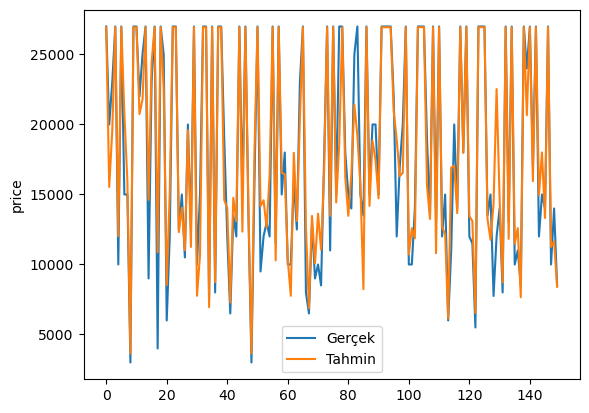

In [87]:
sns.lineplot(x=range(len(y_test[:150])), y=y_test[:150], label="Gerçek")
sns.lineplot(x=range(len(y_test[:150])), y=modelValidate.predict(X_test[:150]), label="Tahmin")

Gördüğümüz gibi veri de bu şekilde tahmin yapmış. İlk 150 veriye baktık çünkü 1600 veride çok sıkışık görünüyordu. Şimdi bir de RandomForest kullanıp sonuçların ne denli değişeceğine bakalım.

mesela veri setimiz 2778 lira bir hata payı veriyordu. bu 25 bin lira kira oranlarımda oldukça gözardı edilebilecek bir oran ama 5 bin lira ve alrı için pek göz ardı edilesi değil. O yüzden bir 7 bin lira ve altı verilerde nasıl işlemler yapıyor bir bakalım.

<Axes: xlabel='None', ylabel='Gercek'>

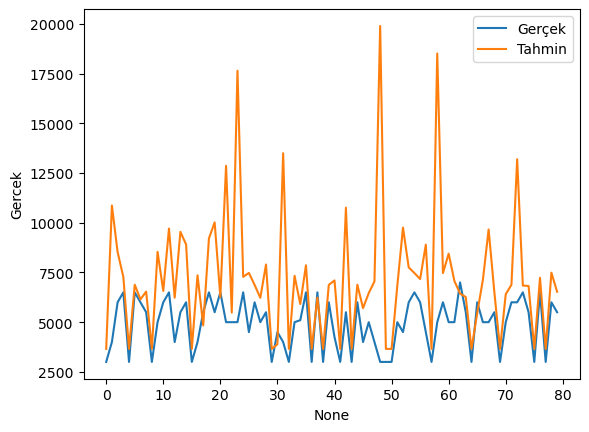

In [163]:
priceData = pd.DataFrame({'Gercek' : y_test, 'Tahmin' : modelValidate.predict(X_test)})
priceDataCh = priceData[priceData.Gercek < 7000].reset_index()
sns.lineplot(priceDataCh, x = priceDataCh.index, y = 'Gercek', label = 'Gerçek')
sns.lineplot(priceDataCh, x = priceDataCh.index, y = 'Tahmin', label = 'Tahmin')

In [165]:
from sklearn.metrics import r2_score

In [169]:
r2_score(priceDataCh.Gercek, priceDataCh.Tahmin)

-8.476918686227313

In [171]:
np.sqrt(mean_squared_error(priceDataCh.Gercek, priceDataCh.Tahmin))

3835.416654696092

Görüldüğü gibi modelde ucuz ev fiyatlarındaki rmse oldukça yüksek ve başarı oranı da çok kötü ama 8000 civarı veriden sadece 80 veri 7 bin lira altı olduğu için etkili gözükmüyor. Bir de pahalı evler için pakalım.

<Axes: xlabel='None', ylabel='Gercek'>

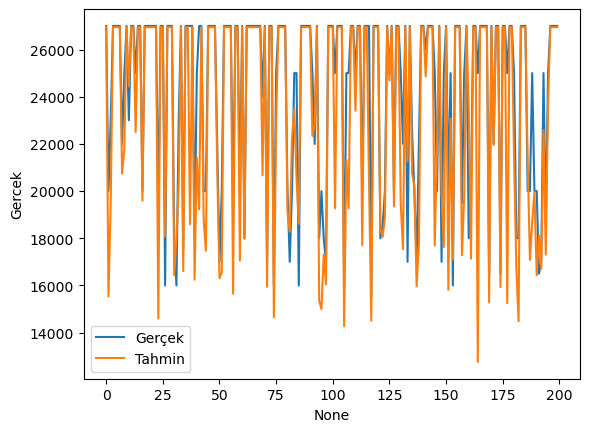

In [180]:
priceDataEx = priceData[priceData.Gercek > 15000].reset_index()
sns.lineplot(x = priceDataEx.index[:200], y = priceDataEx.Gercek[:200], label = 'Gerçek')
sns.lineplot(x = priceDataEx.index[:200], y = priceDataEx.Tahmin[:200], label = 'Tahmin')

In [184]:
print(r2_score(priceDataEx.Gercek, priceDataEx.Tahmin))
np.sqrt(mean_squared_error(priceDataEx.Gercek, priceDataEx.Tahmin))

0.5481805202764873


2626.2909796631407

Yani tekrar söylememe gerek yok, model pahalı verilerde daha başarılıyken ucuz modellerde başaılı görünmüyor bir de ortalama fiyatlar için bakalım.

In [200]:
priceDataMe = priceData[(priceData.Gercek > 7000) & (priceData.Gercek < 15000)].reset_index()
print(r2_score(priceDataMe.Gercek, priceDataMe.Tahmin))
np.sqrt(mean_squared_error(priceDataMe.Gercek, priceDataMe.Tahmin))

-0.9851131038175194


2741.725784940974

Buradan aslında şunu anlayabiliriz GBR ile eğittimiz model yüksek evlerin fiyatlandırma tahminini iyi yapabilirken ucuz evlerin fiyat tahminininde çok da başarılı değil. Bunun sebebine gelecek olursak elimizdeki verideki fiyatlandırmalar eşit şekilde dağılmamış olduğu için olabilir.